In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm , skew
from  scipy import stats
from scipy.special import boxcox
import os 
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import fbeta_score, recall_score, precision_score, average_precision_score, precision_recall_curve
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE ,ADASYN,BorderlineSMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
from collections import Counter
from sklearn.metrics import make_scorer
from time import time
import lightgbm as light
import catboost as cat
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler


Using TensorFlow backend.


In [2]:
def isna_ornot(df,target,new_col) :
    
    list_ = []
    
    for col in df[target].isna() :
        
        if col == True :
            
            list_.append(0)
        else :
            
            list_.append(1)
            
    df[new_col] = list_
        
    return df


def fill_float_na (df,target,lam) :
    
    a = boxcox(df[target].dropna(),lam)
    M = a.sum() / (len(a) - len(a[a == 0]))
    df[target] = df[target].fillna(M)
    
    return df[target]

def fill_float_na1 (df,target,lam) :
    
    a = boxcox(df[target].dropna(),lam)
    M = a.sum() / len(a)
    df[target] = df[target].fillna(M)
    
    return df[target]

def replace_na_to_object (df,target) :
    df[target] = df[target].replace(np.nan(),'未知')
    
    return df

In [3]:
train = pd.read_csv('../../data/train.csv',encoding= 'big5')
test = pd.read_csv('../../data/test.csv',encoding= 'big5')

In [4]:
data_all = pd.concat([train,test],axis=0)
data_all = data_all.reset_index()
Ans = data_all['Y1']
data_all = data_all.drop(['Y1'],axis=1)

In [5]:
data_all_na_col = []
na_num = []
for col in data_all.columns.tolist() :
    if data_all[col].isna().sum() == 0 :
        pass
    else :
        data_all_na_col.append(col)
        na_num.append(data_all[col].isna().sum())
        #print(col,'na_num =',data_all[col].isna().sum())

In [6]:
na_list = []
for col in data_all_na_col :
    if data_all[col].isna().sum()  >= 2000 :
        data_all = isna_ornot(data_all,col,col+'_isna')
    else :
        pass

In [7]:
object_list = []
int_list = []
float_list = []
for col in data_all.columns.tolist() :
    if data_all[col].dtype == 'object' :
        object_list.append(col)
    if data_all[col].dtype == 'int64'  :
        int_list.append(col)
    if data_all[col].dtype == 'float64' :
        float_list.append(col)

In [8]:
for col in object_list :
    if data_all[col].isna().sum() >= 2500 :
        data_all[col].replace(np.nan,'Unknow',inplace=True)
    else :
        pass

In [9]:
nd_fill0_list = []
for col in float_list :
    if (data_all[col] == 0 ).sum() > 2500 :   ### 0 數量是否太多
        nd_fill0_list.append(col)
    
for col in nd_fill0_list :    
    data =(data_all[col] == 0 ).replace([True,False],[1,0])
    data_all[col+'_is0'] = data 

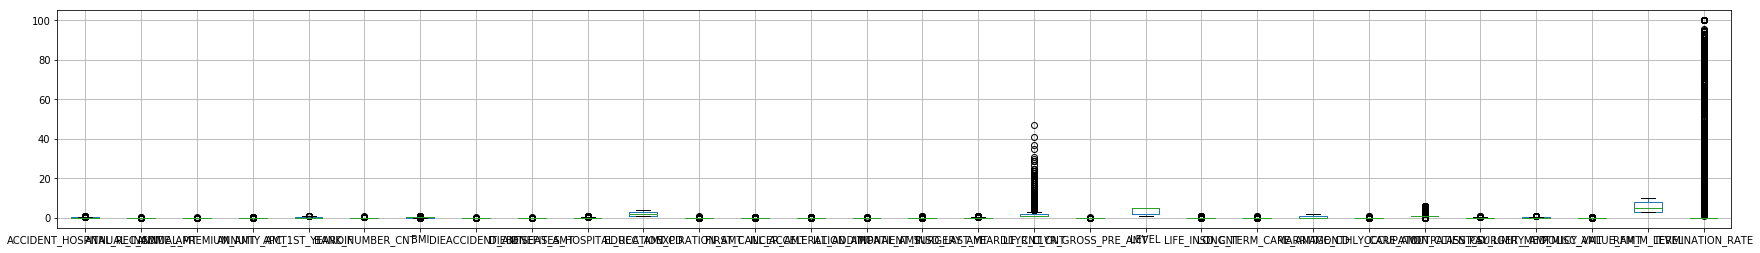

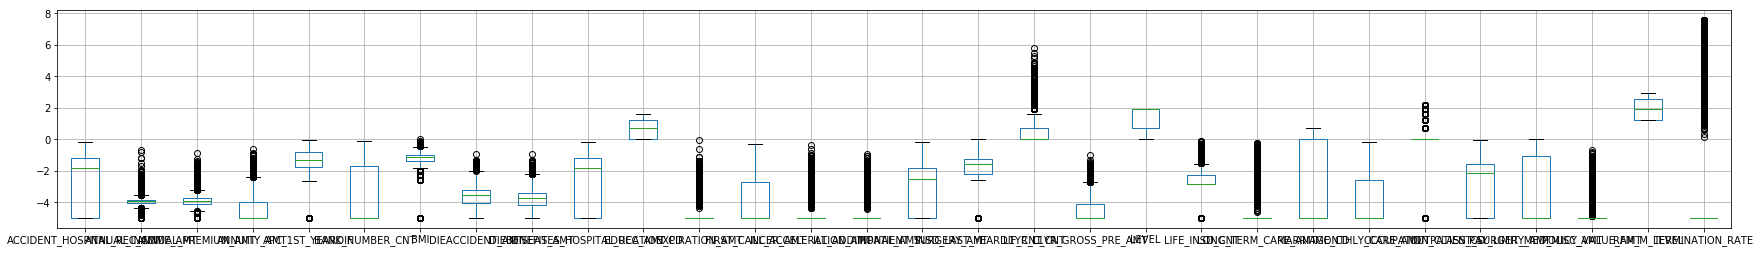

In [10]:
plt.figure(figsize=(30,4))
data_all[float_list].boxplot()
plt.show()

plt.figure(figsize=(30,4))
boxcox(data_all[float_list],0.2).boxplot()
plt.show()

# boxcox lamda 0.2 is the best

In [11]:
##### data1 = annual na = 96620

data1 = data_all[data_all['ANNUAL_INCOME_AMT'].isna()==False]

##### data2 = na_num = 69005

data2 = data_all[data_all['DIEBENEFIT_AMT'].isna()==False]

##### data3 = na_num = 107496

data3 = data_all[data_all['RFM_M_LEVEL'].isna()==False]


In [12]:
dropna_list = []
fillna_list = []
for col in float_list :
    if data_all[col].isna().sum() > 25000 :
        dropna_list.append(col)
    else :
        fillna_list.append(col)
        
data_all.drop(dropna_list,axis=1,inplace=True)

for col in fillna_list :
    data_all[col] = fill_float_na(data_all,col,0.2)
    
    
    
nd_ont_list = []
nd_tar_list = []
for col in object_list :
    nd_ont_list.append(col)
    if len(data_all[col].unique()) >3 :
        nd_tar_list.append(col)

In [13]:
for col in nd_ont_list :
    data_all =pd.concat([data_all] + [pd.get_dummies(data_all[col],prefix=col)] ,axis=1)

data_all.drop(nd_ont_list,axis=1,inplace=True)

In [36]:
ALL = pd.concat([data_all,Ans],axis=1)
test_set = ALL[ALL['Y1'].isna()]
train_set = ALL[ALL['Y1'].isna()==False]

In [37]:
train_set['Y1'].replace(['Y','N'],[1,0],inplace=True)

In [38]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC ,SVC
from sklearn.feature_selection import RFECV

In [17]:
svc = LinearSVC(penalty="l2").fit(train_set.drop(['Y1','index','CUS_ID'],axis=1), train_set['Y1'])
model = SelectFromModel(svc, prefit=True)
X_new = model.transform(train_set.drop(['Y1','index','CUS_ID'],axis=1))
X_new.shape

(100000, 48)

In [17]:
ex = ExtraTreesClassifier().fit(train_set.drop(['Y1','index','CUS_ID'],axis=1), train_set['Y1'])
model = SelectFromModel(ex, prefit=True)
X_new_ex = model.transform(train_set.drop(['Y1','index','CUS_ID'],axis=1))
X_new_ex.shape

(100000, 144)

In [18]:
t_ex = model.transform(test_set.drop(['Y1','index','CUS_ID'],axis=1))

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.1, 
                                                    random_state = 112)

NameError: name 'X_new' is not defined

In [39]:
results={}

In [ ]:
train_set['Y1']

In [79]:
t_ex.shape

(150000, 151)

# full log

No. of 0's and 1's in the feature Class before oversampling the data
0    78389
1     1611
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78792, 0: 78389})
Train Time: 251.84034371376038
Prediction Time: 0.2014601230621338
fbeta score_train: 0.23201724529158158
recall_score_train: 0.7616387337057728
precision_score_train: 0.061356135613561354
Train Time: 251.84034371376038
Prediction Time: 0.2014601230621338
fbeta score: 0.22054287476866136
recall_score: 0.7352185089974294
precision_score: 0.05803571428571429

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     19611
           1       0.06      0.74      0.11       389

    accuracy                           0.76     20000
   macro avg       0.53      0.75      0.49     20000
weighted avg       0.97      0.76      0.85     20000



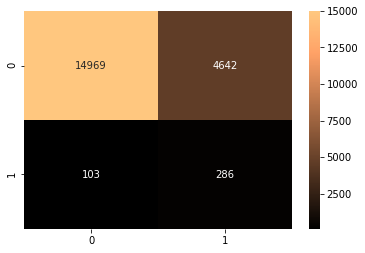

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.2, 
                                                    random_state = 112)


ad_data = X_train.drop(['index', 'CUS_ID'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start


#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=0.3,penalty="l2",solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['CUS_ID','index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['CUS_ID','index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# full balance

No. of 0's and 1's in the feature Class before oversampling the data
0    78389
1     1611
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78792, 0: 78389})
Train Time: 61.37303113937378
Prediction Time: 2.305807113647461
fbeta score_train: 0.8975336892957029
recall_score_train: 0.8764742396027312
precision_score_train: 0.9929676511954993
Train Time: 61.37303113937378
Prediction Time: 2.305807113647461
fbeta score: 0.012714558169103624
recall_score: 0.010282776349614395
precision_score: 0.23529411764705882

Classification report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19611
           1       0.24      0.01      0.02       389

    accuracy                           0.98     20000
   macro avg       0.61      0.50      0.50     20000
weighted avg       0.97      0.98      0.97     20000



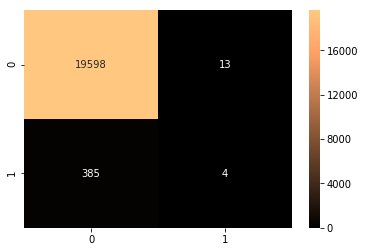

In [40]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.2, 
                                                    random_state = 112)


ad_data = X_train.drop(['index', 'CUS_ID'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['CUS_ID','index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['CUS_ID','index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# full 3000 log

No. of 0's and 1's in the feature Class before oversampling the data
0    78389
1     1611
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78792, 0: 78389})
Train Time: 0.8662381172180176
Prediction Time: 0.1949903964996338
fbeta score_train: 0.22493093407003656
recall_score_train: 0.7479826194909994
precision_score_train: 0.05923704650476846
Train Time: 0.8662381172180176
Prediction Time: 0.1949903964996338
fbeta score: 0.21824795392543195
recall_score: 0.7403598971722365
precision_score: 0.057120190400634666

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     19611
           1       0.06      0.74      0.11       389

    accuracy                           0.76     20000
   macro avg       0.53      0.75      0.48     20000
weighted avg       0.98      0.76      0.84     20000



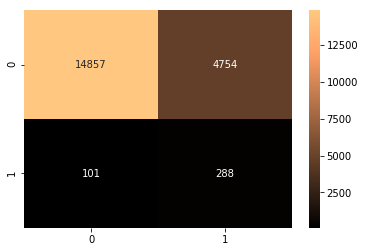

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.2, 
                                                    random_state = 112)


ad_data = X_train.drop(['index', 'CUS_ID'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:3000,0:3000}).fit_resample(X_resampled_ad,y_resampled_ad)

#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=0.3,penalty="l2",solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['CUS_ID','index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['CUS_ID','index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

No. of 0's and 1's in the feature Class before oversampling the data
0    97029
1     1971
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 97029, 1: 96366})
Train Time: 7.397509574890137
Prediction Time: 1.7105960845947266
fbeta score_train: 0.13109531977456507
recall_score_train: 0.10857432775240994
precision_score_train: 0.7697841726618705
Train Time: 7.397509574890137
Prediction Time: 1.7105960845947266
fbeta score: 0.0
recall_score: 0.0
precision_score: 0.0

Classification report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       971
           1       0.00      0.00      0.00        29

    accuracy                           0.97      1000
   macro avg       0.49      0.50      0.49      1000
weighted avg       0.94      0.97      0.96      1000



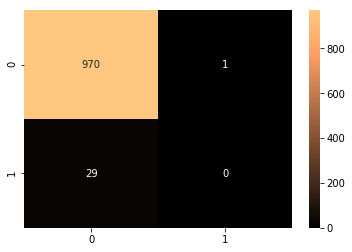

In [48]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.01
                                                    )


ad_data = X_train.drop(['index'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:10000,0:10000}).fit_resample(X_resampled_ad,y_resampled_ad)

#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.2},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

No. of 0's and 1's in the feature Class before oversampling the data
0    97018
1     1982
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 97018, 1: 96860})
Train Time: 8.921103239059448
Prediction Time: 0.1874985694885254
fbeta score_train: 0.23841145411551293
recall_score_train: 0.7426841574167508
precision_score_train: 0.06415900274593558
Train Time: 8.921103239059448
Prediction Time: 0.1874985694885254
fbeta score: 0.18126888217522658
recall_score: 0.6666666666666666
precision_score: 0.04633204633204633

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.75      0.85       982
           1       0.05      0.67      0.09        18

    accuracy                           0.75      1000
   macro avg       0.52      0.71      0.47      1000
weighted avg       0.97      0.75      0.84      1000



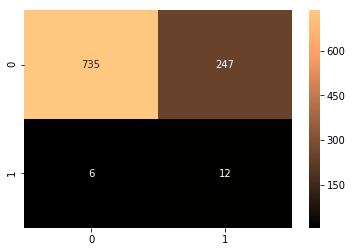

In [49]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.01
                                                    )


ad_data = X_train.drop(['index'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:10000,0:10000}).fit_resample(X_resampled_ad,y_resampled_ad)

#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=0.2,penalty="l2",solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# full 3000 balance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.05
                                                    )


ad_data = X_train.drop(['index'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:12000,0:12000}).fit_resample(X_resampled_ad,y_resampled_ad)

#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=1.5,penalty='none',solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

No. of 0's and 1's in the feature Class before oversampling the data
0    93105
1     1895
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 93105, 1: 92608})


# sampling 3000  lsvc

No. of 0's and 1's in the feature Class before oversampling the data
0    93116
1     1884
Name: Y1, dtype: int64
No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 94024, 0: 93116})
Train Time: 16.319398164749146
Prediction Time: 0.19398713111877441
fbeta score_train: 0.24139221556886226
recall_score_train: 0.7531847133757962
precision_score_train: 0.06492496339677892
Train Time: 16.319398164749146
Prediction Time: 0.19398713111877441
fbeta score: 0.24639423076923078
recall_score: 0.7068965517241379
precision_score: 0.06833333333333333

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      4884
           1       0.07      0.71      0.12       116

    accuracy                           0.77      5000
   macro avg       0.53      0.74      0.50      5000
weighted avg       0.97      0.77      0.85      5000



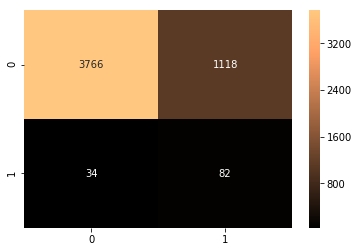

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train_set, 
                                                    train_set['Y1'], 
                                                    test_size = 0.05
                                                    )


ad_data = X_train.drop(['index'], axis=1)

print("No. of 0's and 1's in the feature Class before oversampling the data")
print(ad_data['Y1'].value_counts())


X_ad = ad_data.drop('Y1',axis=1)
y_ad = ad_data['Y1']
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:12000,0:12000}).fit_resample(X_resampled_ad,y_resampled_ad)

#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=1.5,penalty='l2',solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test.drop(['index','Y1'],axis=1))
y_score_ad = clf_ad_BF.predict(X_train.drop(['index','Y1'],axis=1))

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# 3000 lsvc  balaced

No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 79029, 0: 78389})
Train Time: 0.4777224063873291
Prediction Time: 0.9634506702423096
fbeta score_train: 0.228045574057844
recall_score_train: 0.8075729360645562
precision_score_train: 0.05891943299669399
Train Time: 0.4777224063873291
Prediction Time: 0.9634506702423096
fbeta score: 0.18882713410289298
recall_score: 0.6812339331619537
precision_score: 0.04852591100531038

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     19611
           1       0.05      0.68      0.09       389

    accuracy                           0.73     20000
   macro avg       0.52      0.71      0.47     20000
weighted avg       0.97      0.73      0.83     20000



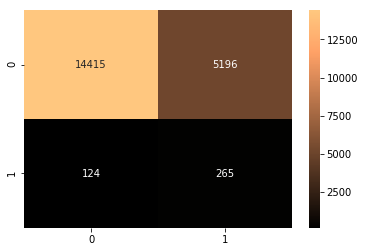

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_new, 
                                                    train_set['Y1'], 
                                                    test_size = 0.2, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:3000,0:3000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# sample 5000 extratree  log

No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78828, 0: 78389})
Train Time: 0.5684795379638672
Prediction Time: 0.02094435691833496
fbeta score_train: 0.23066256932993554
recall_score_train: 0.7641216635630044
precision_score_train: 0.0608201581027668
Train Time: 0.5684795379638672
Prediction Time: 0.02094435691833496
fbeta score: 0.21374045801526717
recall_score: 0.7197943444730077
precision_score: 0.05606728073688426

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     19611
           1       0.06      0.72      0.10       389

    accuracy                           0.76     20000
   macro avg       0.52      0.74      0.48     20000
weighted avg       0.97      0.76      0.85     20000



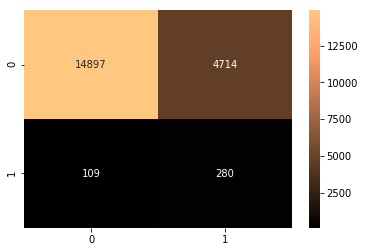

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.2, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:5000,0:5000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=0.3,penalty="l2",solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# 5000 extra balance

No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 68580, 1: 67980})
Train Time: 1.9318616390228271
Prediction Time: 1.0930743217468262
fbeta score_train: 0.367370007535795
recall_score_train: 0.4119718309859155
precision_score_train: 0.2563540753724803
Train Time: 1.9318616390228271
Prediction Time: 1.0930743217468262
fbeta score: 0.1630262741373852
recall_score: 0.17758620689655172
precision_score: 0.12276519666269368

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     29420
           1       0.12      0.18      0.15       580

    accuracy                           0.96     30000
   macro avg       0.55      0.58      0.56     30000
weighted avg       0.97      0.96      0.96     30000



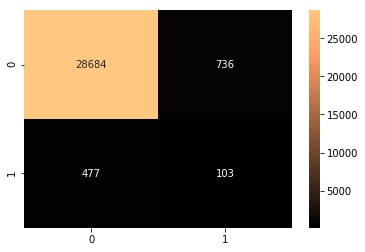

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.3, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:5000,0:5000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# Extra balance 3000 0.2

No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 68580, 1: 67980})
Train Time: 37.73303580284119
Prediction Time: 1.3955295085906982
fbeta score_train: 0.9113123472761249
recall_score_train: 0.8929577464788733
precision_score_train: 0.9929522317932654
Train Time: 37.73303580284119
Prediction Time: 1.3955295085906982
fbeta score: 0.029761904761904764
recall_score: 0.02413793103448276
precision_score: 0.4375

Classification report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29420
           1       0.44      0.02      0.05       580

    accuracy                           0.98     30000
   macro avg       0.71      0.51      0.52     30000
weighted avg       0.97      0.98      0.97     30000



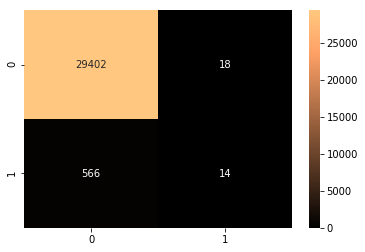

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.3, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
#X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:20000,0:20000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 68580, 1: 68580})
Train Time: 2.1303844451904297
Prediction Time: 1.1437749862670898
fbeta score_train: 0.3541746579721264
recall_score_train: 0.3901408450704225
precision_score_train: 0.2587575899112564
Train Time: 2.1303844451904297
Prediction Time: 1.1437749862670898
fbeta score: 0.15503875968992248
recall_score: 0.16551724137931034
precision_score: 0.12371134020618557

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29420
           1       0.12      0.17      0.14       580

    accuracy                           0.96     30000
   macro avg       0.55      0.57      0.56     30000
weighted avg       0.97      0.96      0.96     30000



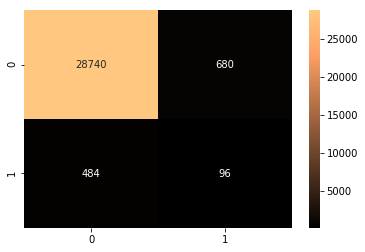

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.3, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = SMOTE(kind='borderline1').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:5000,0:5000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# extra forest 

No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 68580, 1: 67980})
Train Time: 0.09773945808410645
Prediction Time: 0.14464187622070312
fbeta score_train: 0.26203777600425643
recall_score_train: 0.2774647887323944
precision_score_train: 0.21436343852013057
Train Time: 0.09773945808410645
Prediction Time: 0.14464187622070312
fbeta score: 0.13698630136986303
recall_score: 0.14482758620689656
precision_score: 0.1126005361930295

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     29420
           1       0.11      0.14      0.13       580

    accuracy                           0.96     30000
   macro avg       0.55      0.56      0.55     30000
weighted avg       0.97      0.96      0.96     30000



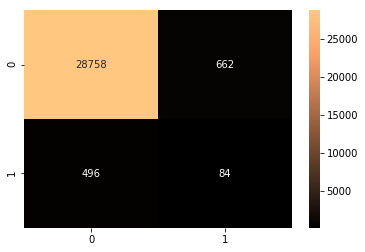

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.3, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:3000,0:3000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = RandomForestClassifier(class_weight={1:1,0:0.7},criterion='entropy').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78828, 0: 78389})
Train Time: 0.23636746406555176
Prediction Time: 0.020943641662597656
fbeta score_train: 0.22156654326870212
recall_score_train: 0.750465549348231
precision_score_train: 0.05801621958827199
Train Time: 0.23636746406555176
Prediction Time: 0.020943641662597656
fbeta score: 0.20901274829528613
recall_score: 0.7249357326478149
precision_score: 0.05433526011560694

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     19611
           1       0.05      0.72      0.10       389

    accuracy                           0.75     20000
   macro avg       0.52      0.74      0.48     20000
weighted avg       0.97      0.75      0.84     20000



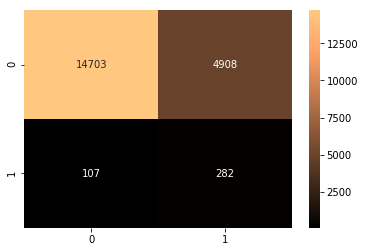

In [47]:
ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:3000,0:3000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = LogisticRegression(C=0.3,penalty="l2",solver='newton-cg').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

# 10000  lsvc  balance

No. of 0's and 1's in the feature Class After oversampling the data
Counter({1: 78828, 0: 78389})
Train Time: 4.100064277648926
Prediction Time: 1.1658809185028076
fbeta score_train: 0.37598776446596993
recall_score_train: 0.36623215394165115
precision_score_train: 0.42082738944365194
Train Time: 4.100064277648926
Prediction Time: 1.1658809185028076
fbeta score: 0.15035538545653365
recall_score: 0.14138817480719795
precision_score: 0.20146520146520147

Classification report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     19611
           1       0.20      0.14      0.17       389

    accuracy                           0.97     20000
   macro avg       0.59      0.57      0.58     20000
weighted avg       0.97      0.97      0.97     20000



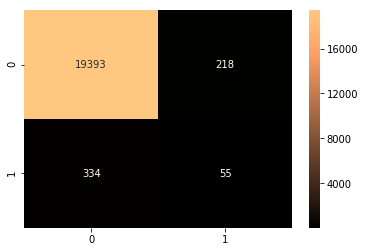

In [48]:
ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = ADASYN(sampling_strategy='minority').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:10000,0:10000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()

In [53]:
ans = clf_ad_BF.predict(test_set.drop(['Y1','index'],axis=1))

In [54]:
sub = pd.read_csv('../../data/submit_test.csv',encoding= 'big5')
sub['Ypred'] = ans

In [55]:
sub['Ypred'].sum()

34545

In [56]:
sub.to_csv('sub9.csv',encoding='big5')

In [ ]:
sub

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new_ex, 
                                                    train_set['Y1'], 
                                                    test_size = 0.15, 
                                                    random_state = 112)


ad_data = X_train

X_ad = ad_data
y_ad = y_train
start = time()
# Oversampling the data using SMOTE

X_resampled_ad, y_resampled_ad = SMOTE(kind='borderline1').fit_sample(X_ad,y_ad)
end = time()
print("No. of 0's and 1's in the feature Class After oversampling the data")
print(Counter(y_resampled_ad))


# Initializng the dictionary to store performance metrics
results['ad'] = {}
results['ad']['resample_time'] = end - start

# Undersample and balance classes
X_resampled_ad, y_resampled_ad = RandomUnderSampler(sampling_strategy={1:10000,0:10000}).fit_resample(X_resampled_ad,y_resampled_ad)


#Training the classifier 
start = time()
clf_ad_BF = BalancedRandomForestClassifier(class_weight={1:1,0:0.3},sampling_strategy='not minority').fit(X_resampled_ad, y_resampled_ad)
end = time()
results['ad']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_ad =clf_ad_BF.predict(X_test)
y_score_ad = clf_ad_BF.predict(X_train)

end = time()
results['ad']['pred_time'] = end - start

results['ad']['fbeta_train'] = fbeta_score(y_train,y_score_ad,beta=2)
results['ad']['recall_train'] = recall_score(y_train,y_score_ad)
results['ad']['precision_train'] = precision_score(y_train,y_score_ad)

results['ad']['fbeta_test'] = fbeta_score(y_test,y_pred_score_ad,beta=2)
results['ad']['recall_test'] = recall_score(y_test,y_pred_score_ad)
results['ad']['precision_test'] = precision_score(y_test,y_pred_score_ad)

print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])


print('========================================================')
print ("Train Time:", results['ad']['train_time'])
print ("Prediction Time:", results['ad']['pred_time'])
print ("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])


# Classification report
print('\nClassification report:\n')
print(classification_report(y_test, y_pred_score_ad))

conf_matrix = confusion_matrix(y_test,y_pred_score_ad)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()